# Numerical code for the RF model

In [12]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict, OrderedDict
import matplotlib
from matplotlib.gridspec import GridSpec
import sys
import random
import copy
import sklearn
import skimage
import sklearn
import itertools
sys.path.append('.')

%load_ext autoreload
%autoreload 2

cmap = plt.get_cmap('viridis')
plt.rcParams.update(plt.rcParamsDefault)
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font',       family='serif')          # controls default text sizes
plt.rc('font',       size=2*MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes',  titlesize=2*MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes',  labelsize=2*MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=2*SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=2*SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=2*SMALL_SIZE)    # legend fontsize
plt.rc('figure',titlesize=2*BIGGER_SIZE)  # fontsize of the figure title
plt.rc("lines", linewidth=3.0)
plt.rcParams["savefig.dpi"] = 500
cmap = plt.get_cmap('Spectral_r')

savedir = './figs/'
datadir = './data/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Helpers

In [2]:
def dict_product(d):
    keys = d.keys()
    for element in itertools.product(*d.values()):
        yield dict(zip(keys, element))
        
def generate_orthogonal(D, P, eps=1, max_iter=100):
    from scipy.stats import ortho_group
    U = torch.from_numpy(ortho_group.rvs(P)).float()
    V = torch.from_numpy(ortho_group.rvs(D)).float()
    S = torch.zeros((P, D))
    for i in range(min(D,P)):
        S[i,i] = D**0.5 * max(1, (D/P)**0.5)
    points = U @ S @ V
    return points

def generate_rfs(K,D,P,init='gaussian'):
    rfs = []
    for k in range(K):
        if init=='gaussian':
            rf = torch.randn((D,P))
        elif init=='orthogonal':
            rf = generate_orthogonal(D, P).t()
        elif init=='even':
            rf = generate_even(D, P, lr=10, eps=.0, max_iter=10).t()
        rfs.append(rf)
    rf = torch.stack(rfs)
    return rf


def get_dataset(dataset, D=None, N_train=10000, N_test=10000, norm=1, resize_method='PCA', cov=None, whiten_pow=0):
    
    if dataset=='random':
        if cov is None:
            tr_x = torch.randn((N_train,D))
            te_x = torch.randn((N_test,D))
        else:
            tr_x = torch.from_numpy(np.random.multivariate_normal(mean=np.zeros(D),cov=cov,size=(N_train))).float()
            te_x = torch.from_numpy(np.random.multivariate_normal(mean=np.zeros(D),cov=cov,size=(N_test ))).float()
        tr_y, te_y = None, None

    else:
        import utils
        if dataset=='MNIST':
            tr_data, te_data, input_size, output_size = utils.get_data(dataset, n=N_train, d=D)
        else:
            tr_data, te_data, input_size, output_size = utils.get_data(dataset, n=N_train, d=D, num_classes=2, classes_modulo=False)            
        if D is not None:
            if resize_method=='pca':
                tr_data, te_data = utils.get_pca(tr_data, te_data, D, normalized=False)
            elif resize_method=='downsample':
                tr_data, te_data = utils.resize_data(tr_data, te_data, D)
            else:
                raise
        tr_x = tr_data.data.reshape(tr_data.data.size(0), -1)
        te_x = te_data.data.reshape(te_data.data.size(0), -1)
        tr_x = tr_x-tr_x.mean(dim=0)#+1.e-6*torch.randn_like(tr_x)
        te_x = te_x-te_x.mean(dim=0)#+1.e-6*torch.randn_like(te_x)
        tr_x = tr_x/tr_x.std(dim=0)**whiten_pow
        te_x = te_x/te_x.std(dim=0)**whiten_pow
        tr_x = tr_x/tr_x.std()
        te_x = te_x/te_x.std()
        tr_y = ((tr_data.targets%2-0.5)*2).int()
        te_y = ((te_data.targets%2-0.5)*2).int()
                
    return tr_x, te_x, tr_y, te_y
    
def get_act(actname):
    if actname=='relu':
        return lambda x : F.relu(x)
    elif actname=='abs':
        return lambda x : abs(x)
    elif actname=='tanh':
        return lambda x : torch.tanh(x)
    elif actname=='linear':
        return lambda x : x
    elif type(actname)!=str: 
        alpha=actname
        return lambda x : (F.relu(x) + alpha*F.relu(-x) - (1+alpha)/np.sqrt(2*np.pi))/np.sqrt((1+alpha**2)/2 - (1+alpha)**2/(2*np.pi))
    else:
        raise NotImplemented
        
bceloss = torch.nn.BCEWithLogitsLoss()
def get_train_loss(act, rf, a, te_data, y_test, loss='square'):
            
    D,P=rf.size()
    y_pred = torch.einsum('np,p->n',(act(te_data @ rf / D**0.5) / D**0.5, a))
    if loss == 'square':
        error = (y_pred-y_test).pow(2).mean() / 2
    elif loss == 'logistic':
        #error = sklearn.metrics.log_loss((1+y_test[k])/2, torch.sigmoid(y_pred), eps=1e-15)
        error = bceloss(y_pred, (1+y_test)/2)

    return error

def get_test_error(act, rf, a, te_data, y_test, task='regression'):
            
    D,P=rf.size()

    y_pred = torch.einsum('np,p->n',(act(te_data @ rf / D**0.5) / D**0.5, a))
    if task == 'classification':
        y_pred = y_pred.sign()
    error = (y_pred-y_test).pow(2).mean() / 2
    if task == 'classification':
        error /= 2
    
    return error

# RF on strong and weak features

In [3]:
from sklearn.linear_model import LogisticRegression

def run_rf_random(args):
    
    D, K = args['D'], args['K']
    
    rx, rb, rphi = args['rx'], args['rb'], args['rphi']
    cov = torch.zeros((D,D))
    ds = np.array([1/rphi, 1-1/rphi])
    cs = np.array([rx/(rx*ds[0]+ds[1]), 1/(rx*ds[0]+ds[1])])
    betas = np.array([rb/(rb*ds[0]*cs[0]+ds[1]*cs[1]), 1/(rb*ds[0]*cs[0]+ds[1]*cs[1])])
    
    tr_errors = []
    tr_errors_std = []
    te_errors = []
    te_errors_std = []    
    
    for i, Psi1 in enumerate(args['Psi1_list']):
        for j, Psi2 in enumerate(args['Psi2_list']):
            
            tr_errors_tmp = []
            te_errors_tmp = []
            for k in range(K):
                
                for i in range(D):
                    if i < int(D/rphi) : 
                        cov[i,i] = cs[0]
                    else : 
                        cov[i,i] = cs[1]
                beta = torch.zeros(D)
                beta[:int(D/rphi)] = betas[0]**.5 * torch.randn(int(D/rphi))
                beta[int(D/rphi):] = betas[1]**.5 * torch.randn(D-int(D/rphi))

                teacher = lambda x : x @ beta / D**0.5 

                tr_data, te_data, y, y_test = get_dataset(args['dataset'], D, N_train=int(D*max(args['Psi2_list'])), N_test=args['N_test'], cov=cov)
                act = get_act(args['actname'])

                y_test = teacher(te_data)
                if args['task']=='classification': y_test = y_test.sign()

                P = int(D * Psi1)
                N = int(D * Psi2)
                rf = generate_rfs(1,D,P,init='gaussian')[0]

                X = tr_data[:N]
                y = teacher(X)
                if args['task']=='classification': 
                    y = y.sign()
                    y *= ((np.random.uniform(0,1,size=(N))>args['tau']).astype(int)-.5)*2
                    y = y.float()
                else: y += args['tau']**.5 * torch.randn((N))

                a = torch.empty((P))

                Z = act(X @ rf / D**0.5) / D**0.5
                if args['loss'] == "square":
                    a = y @ Z @ torch.from_numpy(np.linalg.pinv((Z.t() @ Z + .5 * args['lam'] * torch.eye(P)).numpy()))
                else:
                    model = sklearn.linear_model.LogisticRegression(tol=1e-4, max_iter=10000, C=1/args['lam'])
                    model.fit(Z.numpy(),y.numpy())
                    a = torch.from_numpy(model.coef_)[0].float()

                tr_error = get_train_loss(act, rf, a, X, y           , loss=args['loss'])
                te_error = get_test_error(act, rf, a, te_data, y_test, task=args['task'])
                tr_errors_tmp.append(tr_error)
                te_errors_tmp.append(te_error)
            
            tr_errors.append(np.mean(tr_errors_tmp))
            tr_errors_std.append(np.std(tr_errors_tmp))
            te_errors.append(np.mean(te_errors_tmp))
            te_errors_std.append(np.std(te_errors_tmp))   

    run = {'args':copy.deepcopy(args),
           'tr_error':tr_errors,
           'tr_error_std':tr_errors_std,
           'te_error':te_errors,
           'te_error_std':te_errors_std}
    return run

# Numerical data for figs 2 and 4

In [ ]:
args = {'D': 150,
    'Psi2_list'  : [1],
    'Psi1_list' : np.logspace(-1,1,19),
    'N_test' : 5000,
    'K' : 10,
    'lam' : 1e-3,
    'actname': 'tanh',
    'dataset' : 'random',
    'rphi': 10,
    'loss':'logistic'}

constraints = {'tau':[0.0,0.3],
       'task':['classification','regression']}

for cons in dict_product(constraints):
    args['tau']=cons['tau']
    args['task']=cons['task'] 
    if args['loss']=='logistic' and args['task']!='classification':continue
    runs = {}
    for rx in [1,100]:
        for irb, rb in enumerate([0.01,100]):
            print(rx, rb)
            if rx==1 and irb>0: continue
            args['rx'], args['rb'] = rx, rb
            run = run_rf_random(args)
            runs[(rx,rb)]=run
    if len(args['Psi1_list'])>1:
        title = datadir+'parameter_wise_{}_{}_{}'.format(args['task'], args['loss'], args['tau'])
    else:
        title = datadir+   'sample_wise_{}_{}_{}'.format(args['task'], args['loss'], args['tau'])
    title += '.pyT'
    torch.save(runs, title)

# RF on real data

In [13]:
from sklearn.linear_model import LogisticRegression
def run_rf(args):
    
    D, K = args['D'], args['K']
    
    tr_errors = []
    tr_errors_std = []
    te_errors = []
    te_errors_std = []   
    
    tr_data, te_data, tr_labels, te_labels = get_dataset(args['dataset'], D, N_train=int(D*max(args['Psi2_list'])), N_test=args['N_test'], 
                                              resize_method='pca', whiten_pow=args['whiten_pow'])

    
    for i, Psi1 in enumerate(args['Psi1_list']):
        for j, Psi2 in enumerate(args['Psi2_list']):
            
            tr_errors_tmp = []
            te_errors_tmp = []
            
            P = int(D * Psi1)
            N = int(D * Psi2)
            X = tr_data[:N]
            y = tr_labels[:N]
            
            for k in range(K):
                
                act = get_act(args['actname'])
                rf = generate_rfs(1,D,P,init='gaussian')[0]

                if args['task']=='classification': 
                    y = y.sign()
                    y *= ((np.random.uniform(0,1,size=(N))>args['tau']).astype(int)-.5)*2
                    y = y.float()
                else: y += args['tau']**.5 * torch.randn((N))

                a = torch.empty((P))

                Z = act(X @ rf / D**0.5) / D**0.5
                if args['loss'] == "square":
                    a = y @ Z @ torch.from_numpy(np.linalg.pinv((Z.t() @ Z + .5 * args['lam'] * torch.eye(P)).numpy()))
                else:
                    model = sklearn.linear_model.LogisticRegression(tol=1e-6, max_iter=10000, C=1/args['lam'])
                    model.fit(Z.numpy(),y.numpy())
                    a = torch.from_numpy(model.coef_)[0].float()

                tr_error = get_train_loss(act, rf, a, X, y           , loss=args['loss'])
                te_error = get_test_error(act, rf, a, te_data, te_labels, task=args['task'])
                tr_errors_tmp.append(tr_error)
                te_errors_tmp.append(te_error)
            
            tr_errors.append(np.mean(tr_errors_tmp))
            tr_errors_std.append(np.std(tr_errors_tmp))
            te_errors.append(np.mean(te_errors_tmp))
            te_errors_std.append(np.std(te_errors_tmp))   

    run = {'args':copy.deepcopy(args),
           'tr_error':tr_errors,
           'tr_error_std':tr_errors_std,
           'te_error':te_errors,
           'te_error_std':te_errors_std}
    return run

# Data for Fig 6

In [ ]:
dataset='CIFAR10'

args = {'D': 100,
    'Psi2_list'  : [1],
    'Psi1_list' : np.logspace(-1.,1.,19),
    'N_test' : 5000,
    'K' : 20,
    'lam' : 1e-3,
    'actname': 'tanh',
    'dataset' : dataset,
    'loss':'square',
    'rx':1,'rb':1,'rphi':1}

model = "rf"

constraints = {'tau':[0.],
                'loss':['square','logistic'],
                'task':['classification']}

for cons in dict_product(constraints):
    args['tau']=cons['tau']
    args['task']=cons['task'] 
    args['loss']=cons['loss'] 
    if args['loss']=='logistic' and args['task']!='classification':continue
    runs = {}
    for whiten_pow in [1,1.25,0]:
        print(whiten_pow)
        args['whiten_pow']=whiten_pow
        if model=="nn":
            run = run_nn(args)
        elif model=="rf":
            run = run_rf(args)
        runs[whiten_pow]=run
    if len(args['Psi1_list'])>1:
        title = datadir+'parameter_wise_{}_{}_{}'.format(args['task'], args['loss'], args['tau'])
    else:
        title = datadir+   'sample_wise_{}_{}_{}'.format(args['task'], args['loss'], args['tau'])
    if dataset!='random':
        title += '_{}'.format(dataset)
    title += '.pyT'
    torch.save(runs, title)

# Fig 6

parameter_wise_classification_square_0.0_MNIST


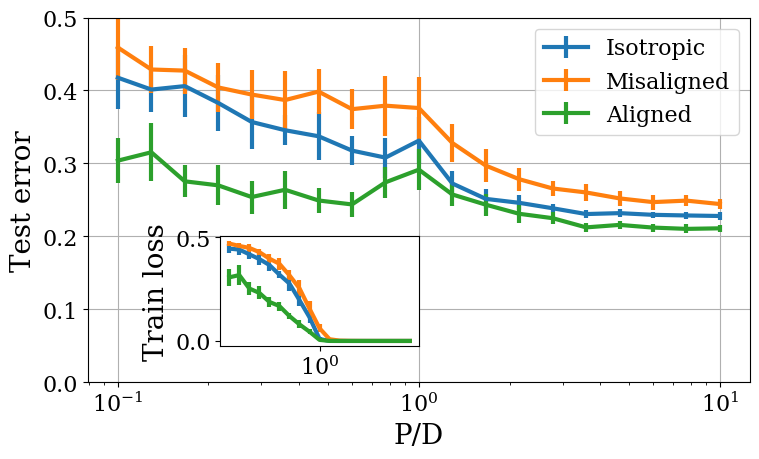

parameter_wise_classification_logistic_0.0_MNIST


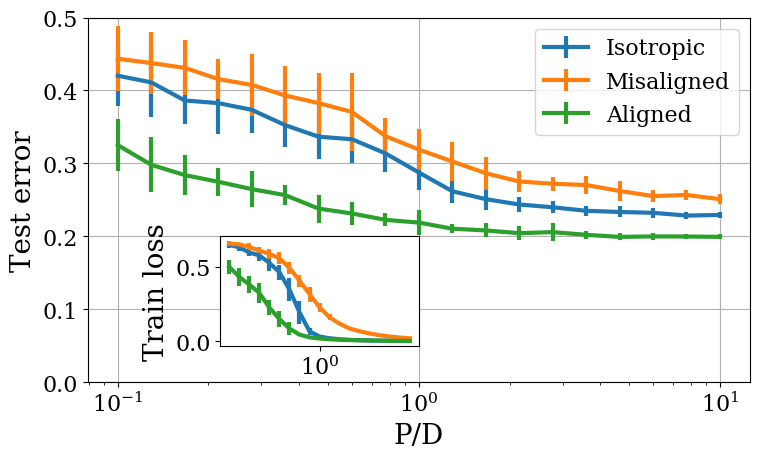

In [16]:
train = False
observable = 'tr_error' if train else 'te_error'
label = 'Train loss' if train else 'Test error'

labels={1:'Isotropic',0:'Aligned',1.25:'Misaligned'}

for plot_type in ['parameter_wise']:
    for tau in [0.0]:
        for loss in ['square','logistic']:
            plt.figure(figsize=(8,5))
            axins=plt.gca().inset_axes([.2,.1,.3,.3])
            
            title = plot_type+'_classification_{}_{}_MNIST'.format(loss,tau)
            print(title)
            runs = torch.load(datadir+title+'.pyT')
            for whiten, run in runs.items():
                args=run['args']
                x = args['Psi1_list'] if plot_type=='parameter_wise' else args['Psi2_list']
                plt.errorbar(x, run[observable], yerr=run[observable+'_std'], label=labels[whiten])
                axins.errorbar(x, run['tr_error'], yerr=run['tr_error_std'], label=labels[whiten])
            
            axins.set_xscale('log')
            axins.set_ylabel('Train loss')
                
            plt.xscale('log')
            if plot_type == 'parameter_wise':
                plt.xlabel('P/D')
            else: 
                plt.xlabel('N/D')
            plt.ylabel(label)
            if not train: plt.ylim(0,.5)
            plt.legend()
            plt.grid(True)

            plt.tight_layout()
            #plt.savefig(savedir+title+'_{}.pdf'.format(observable))
            plt.show()


# Data for Fig 3b

In [ ]:
dataset='MNIST'

args = {'D': 100,
    'Psi2_list'  : [1],
    'Psi1_list' : [10],
    'N_test' : 5000,
    'K' : 10,
    'lam' : 1e-3,
    'actname': 'tanh',
    'dataset' : dataset,
    'loss':'square',
    'rx':1,'rb':1,'rphi':1}

model = "rf"

constraints = {'tau':[0.0],
                'loss':['square','logistic'],
                'task':['classification']}

for cons in dict_product(constraints):
    args['tau']=cons['tau']
    args['task']=cons['task'] 
    args['loss']=cons['loss'] 
    if args['loss']=='logistic' and args['task']!='classification':continue
    runs = {}
    for whiten_pow in np.logspace(-2,2,9,base=2):
        print(whiten_pow)
        args['whiten_pow']=whiten_pow
        if model=="nn":
            run = run_nn(args)
        elif model=="rf":
            run = run_rf(args)
        runs[whiten_pow]=run
    title = datadir+'anisotropy_{}_{}_{}'.format(args['task'], args['loss'], args['tau'])
    if dataset!='random':
        title += '_{}'.format(dataset)
    title += '.pyT'
    torch.save(runs, title)

# Fig 3b

anisotropy_classification_logistic_0.0_MNIST
anisotropy_classification_square_0.0_MNIST
anisotropy_classification_logistic_0.0_CIFAR10
anisotropy_classification_square_0.0_CIFAR10


/Users/sdascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  app.launch_new_instance()


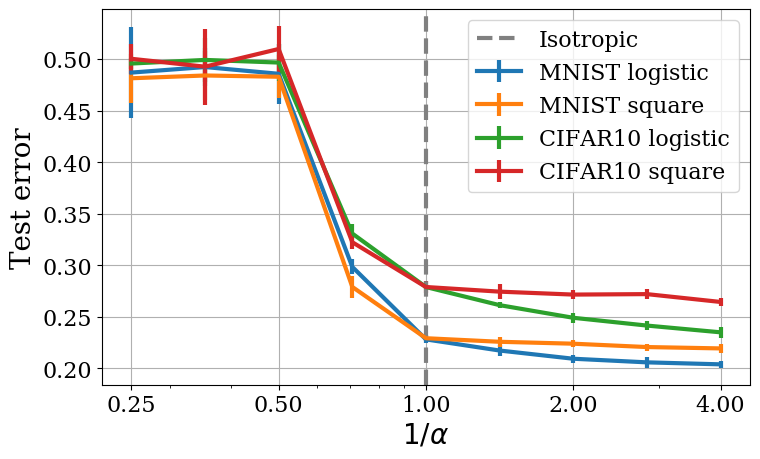

In [19]:
from matplotlib.ticker import ScalarFormatter

train = False
observable = 'tr_error' if train else 'te_error'
label = 'Train loss' if train else 'Test error'

labels={1:'Isotropic',0:'Aligned',2:'Misaligned',1.5:'Misaligned'}

plt.figure(figsize=(8,5))
for dataset in ['MNIST','CIFAR10']:
    for loss in ['logistic','square']:
        title = 'anisotropy_classification_{}_0.0_{}'.format(loss.lower(),dataset)
        print(title)
        runs = torch.load(datadir+title+'.pyT')
        label = '{} {}'.format(dataset, loss)
        plt.errorbar([1/k for k in runs.keys()], [runs[k][observable] for k in runs.keys()], yerr=np.array([runs[k][observable+'_std'] for k in runs.keys()]), label=label)

plt.axvline(x=1, label='Isotropic', ls='--', color='grey')
plt.xlabel(r'$1/\alpha$')

plt.ylabel('Test error')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.gca().set_xticks([.25,.5,1,2,4])
plt.gca().get_xaxis().set_major_formatter(ScalarFormatter())

plt.tight_layout()
plt.savefig(savedir+'anisotropy.pdf')
plt.show()
